In [ ]:
!kaggle datasets download -d greedyfornothing/multiclass-semantic-ct-scan-liver-tumor

Dataset URL: https://www.kaggle.com/datasets/greedyfornothing/multiclass-semantic-ct-scan-liver-tumor
License(s): unknown
 99% 657M/665M [00:08<00:00, 95.4MB/s]
100% 665M/665M [00:08<00:00, 78.3MB/s]


In [ ]:
# Unzipping the file to the current directory or a specified folder
!unzip /content/multiclass-semantic-ct-scan-liver-tumor.zip -d /content/multiclass-semantic-ct-scan-liver-tumor


Streaming output truncated to the last 5000 lines.
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_240.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_241.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_242.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_243.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_244.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_245.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_246.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_247.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_C

In [ ]:
# Install a specific version of albumentations that contains JpegCompression and RandomBrightness
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=6717f4d2573f35afa6481c80a420d6e49a15cb77473b71535531b39ce9dfa319
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
from albumentations import (
    Compose, RandomBrightnessContrast, ImageCompression, HueSaturationValue, RandomContrast,
    HorizontalFlip, Rotate, GridDistortion, ElasticTransform
)


In [ ]:
transforms = Compose([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5)])

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [ ]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [ ]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)

    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]

    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan',
                                            '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'), train_y))


    train_x, valid_x = train_test_split(train_x, test_size=0.15, random_state=0)
    train_y, valid_y = train_test_split(train_y, test_size=0.15, random_state=0)

    return (train_x, train_y), (valid_x, valid_y)

In [ ]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x,y):

    def aug_fn(image, mask):
        img_data = {"image":image}
        mask_data = {"mask":mask}
        img_data = transforms(**image)
        mask_data = transforms(**mask)
        aug_img = img_data["image"]
        aug_mask = mask_data["mask"]
        return aug_img, aug_mask

    def f(x,y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)
        augmented = transforms(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']

        return aug_img, aug_mask

    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    #image, mask = tf.numpy_function(aug_fn,[image, mask],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.int32)
    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [ ]:
!pip install timm
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32)) # Cast y_true to float32
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_3Class(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [ ]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

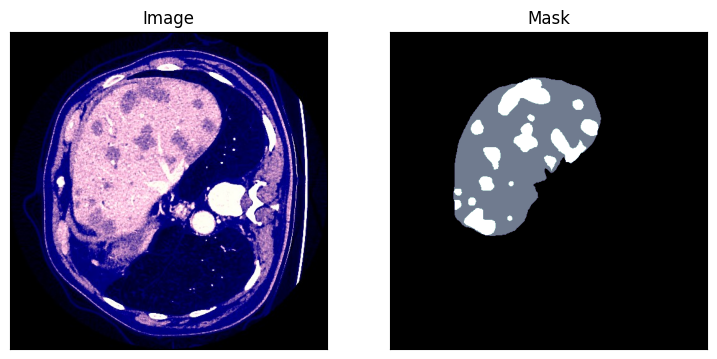

In [ ]:
if __name__ == "__main__":

    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    i = random.randint(0, 6100)

    """ Dataset """
    train_frame_path = '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    train_mask_path = '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'

    (train_x, train_y), (valid_x, valid_y) = load_data(train_frame_path, train_mask_path)

    visualize(image = read_image(train_x[i]), mask = read_mask(train_y[i]))


    #hyperparameters
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    IMG_CHANNELS = 3
    n_classes = 3
    #weights = [0.35983807, 6.597887, 14.40744607]

    lr = 1e-4
    batch_size = 4
    epochs = 5


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define a Swin Transformer Block
def swin_transformer_block(x, num_blocks=2, embed_dim=96, num_heads=4, window_size=7):
    for _ in range(num_blocks):
        x = Conv2D(embed_dim, (3, 3), padding="same", activation="relu")(x)
    return x

# Define Patch Merging for downsampling
def patch_merging(x, embed_dim=96):
    x = Conv2D(embed_dim, (2, 2), strides=(2, 2), padding="same")(x)
    return x

# Define Patch Expanding for upsampling
def patch_expanding(x, embed_dim=96):
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(embed_dim, (3, 3), padding="same", activation="relu")(x)
    return x

# SwinUNet Model function
def swin_unet_model(input_shape=(512, 512, 3), n_classes=3):
    inputs = Input(input_shape)

    # Encoder
    x = Dense(96)(inputs)  # Initial embedding layer

    # First Level of Encoder
    x1 = swin_transformer_block(x, num_blocks=2, embed_dim=96)
    x1_p = patch_merging(x1, embed_dim=96)

    # Second Level of Encoder
    x2 = swin_transformer_block(x1_p, num_blocks=2, embed_dim=192)
    x2_p = patch_merging(x2, embed_dim=192)

    # Third Level of Encoder
    x3 = swin_transformer_block(x2_p, num_blocks=6, embed_dim=384)
    x3_p = patch_merging(x3, embed_dim=384)

    # Fourth Level of Encoder
    x4 = swin_transformer_block(x3_p, num_blocks=2, embed_dim=768)

    # Bottleneck
    bottleneck = swin_transformer_block(x4, num_blocks=2, embed_dim=768)

    # Decoder
    u1 = patch_expanding(bottleneck, embed_dim=384)
    u1 = concatenate([u1, x3])
    u1 = swin_transformer_block(u1, num_blocks=2, embed_dim=384)

    u2 = patch_expanding(u1, embed_dim=192)
    u2 = concatenate([u2, x2])
    u2 = swin_transformer_block(u2, num_blocks=2, embed_dim=192)

    u3 = patch_expanding(u2, embed_dim=96)
    u3 = concatenate([u3, x1])
    u3 = swin_transformer_block(u3, num_blocks=2, embed_dim=96)

    # Output Layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u3)

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model
# Instantiate the model
model = swin_unet_model(input_shape=(512, 512, 3), n_classes=3)

# Generate a one-line summary of layer names and shapes
layer_summary = " | ".join([f"{layer.name}: {layer.output.shape}" for layer in model.layers if hasattr(layer.output, 'shape')])

# Print the summary
print(layer_summary)



input_layer: (None, 512, 512, 3) | dense: (None, 512, 512, 96) | conv2d: (None, 512, 512, 96) | conv2d_1: (None, 512, 512, 96) | conv2d_2: (None, 256, 256, 96) | conv2d_3: (None, 256, 256, 192) | conv2d_4: (None, 256, 256, 192) | conv2d_5: (None, 128, 128, 192) | conv2d_6: (None, 128, 128, 384) | conv2d_7: (None, 128, 128, 384) | conv2d_8: (None, 128, 128, 384) | conv2d_9: (None, 128, 128, 384) | conv2d_10: (None, 128, 128, 384) | conv2d_11: (None, 128, 128, 384) | conv2d_12: (None, 64, 64, 384) | conv2d_13: (None, 64, 64, 768) | conv2d_14: (None, 64, 64, 768) | conv2d_15: (None, 64, 64, 768) | conv2d_16: (None, 64, 64, 768) | up_sampling2d: (None, 128, 128, 768) | conv2d_17: (None, 128, 128, 384) | concatenate: (None, 128, 128, 768) | conv2d_18: (None, 128, 128, 384) | conv2d_19: (None, 128, 128, 384) | up_sampling2d_1: (None, 256, 256, 384) | conv2d_20: (None, 256, 256, 192) | concatenate_1: (None, 256, 256, 384) | conv2d_21: (None, 256, 256, 192) | conv2d_22: (None, 256, 256, 192) |

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)


In [ ]:
train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

history_class = LossHistory()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint("Multiclass-Semantic_one_hot_encoder_catcross_SNet.keras",
                    monitor='val_loss',
                    save_best_only=True,  # Save only the best model
                    verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    #EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.001),
]

In [ ]:
model.compile(loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(lr), metrics = ['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)] )

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/4
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9528 - dice_coef_3_class: 0.5524 - loss: 0.1593 - one_hot_mean_io_u: 0.2735
Epoch 1: val_loss improved from inf to 0.05812, saving model to Multiclass-Semantic_one_hot_encoder_catcross_SNet.keras
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 3841s 2s/step - accuracy: 0.9528 - dice_coef_3_class: 0.5525 - loss: 0.1593 - one_hot_mean_io_u: 0.2735 - val_accuracy: 0.9787 - val_dice_coef_3_class: 0.7012 - val_loss: 0.0581 - val_one_hot_mean_io_u: 0.6353 - learning_rate: 1.0000e-04
Epoch 2/4
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9799 - dice_coef_3_class: 0.7157 - loss: 0.0556 - one_hot_mean_io_u: 0.5118
Epoch 2: val_loss improved from 0.05812 to 0.04363, saving model to Multiclass-Semantic_one_hot_encoder_catcross_SNet.keras
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 3755s 2s/step - accuracy: 0.9799 - dice_coef_3_class: 0.7157 - loss: 0.0556 - one_hot_mean_io_u: 0.5117 - val_accuracy: 0.9843 - val_dice_coef_3_class: 0.7936 - val_loss: 0

In [ ]:
model.save('Final_model_Multiclass-Semantic_one_hot_encoder_catcross_SNET.keras')

In [ ]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
def plot_segm_history_acc(history, metrics=["accuracy", "val_accuracy"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)

    #plt.suptitle("Accuracy V epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
      # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_acc(history)

In [ ]:
def plot_segm_history_dice(history, metrics=["dice_coef_3_class", "val_dice_coef_3_class"], losses=["loss", "val_loss"]): # Changed metrics to dice_coef and val_dice_coef
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history: # Check if the metric exists in the history
            plt.plot(history.history[metric], linewidth=3)
        else:
            print(f"Metric '{metric}' not found in history.")
    #plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_dice(history)

In [ ]:
def plot_segm_history_one_hot(history, metrics=["one_hot_mean_io_u_1", "val_one_hot_mean_io_u_1"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    #plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_one_hot(history)

In [ ]:
def plot_segm_history(history, metrics=["accuracy", "val_accuracy","dice_coef_3_class","val_dice_coef_3_class", "one_hot_mean_io_u_1", "val_one_hot_mean_io_u_1"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

plot_segm_history(history)

In [ ]:
os.mkdir('/content/val_masks')
os.listdir('./')

['.config',
 'multiclass-semantic-ct-scan-liver-tumor',
 'drive',
 'multiclass-semantic-ct-scan-liver-tumor.zip',
 'val_masks',
 'Multiclass-Semantic_one_hot_encoder_catcross_SNet.keras',
 'sample_data']

In [ ]:
from tqdm import tqdm
from PIL import Image

for x in tqdm(valid_x, total = len(valid_x), position = 0, leave=True):
    name = x.split('/')[-1]
    name = name.replace('.jpg', '.tiff')

    x = read_image(x)

    p = model.predict(np.expand_dims(x,axis=0))[0]
    p = np.argmax(p, axis=-1)
    #print(np.unique(p, return_counts=True))
    p = np.expand_dims(p, axis=-1)
    p = p.astype(np.int32)
    p = np.squeeze(p, axis=-1)

    img = Image.fromarray(p.astype('uint8'), mode = 'L')
    img.save(f"./val_masks/{name}")

  0%|          | 0/1078 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 1/1078 [00:11<3:33:57, 11.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 2/1078 [00:12<1:32:07,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 3/1078 [00:12<52:17,  2.92s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 4/1078 [00:12<34:30,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 5/1078 [00:13<23:39,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 6/1078 [00:13<17:50,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 7/1078 [00:13<13:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 8/1078 [00:14<10:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 9/1078 [00:14<08:41,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 10/1078 [00:14<07:59,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 11/1078 [00:14<06:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 12/1078 [00:15<06:08,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 13/1078 [00:15<06:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▏         | 14/1078 [00:15<06:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 15/1078 [00:16<05:43,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  1%|▏         | 16/1078 [00:16<05:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 17/1078 [00:16<05:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 18/1078 [00:16<04:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 19/1078 [00:17<04:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 20/1078 [00:17<04:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 21/1078 [00:17<04:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 22/1078 [00:17<04:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 23/1078 [00:18<05:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 24/1078 [00:18<05:30,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 25/1078 [00:18<05:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 26/1078 [00:19<04:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 27/1078 [00:19<04:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 28/1078 [00:19<04:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 29/1078 [00:20<04:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 30/1078 [00:20<04:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 31/1078 [00:20<04:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 32/1078 [00:20<04:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 33/1078 [00:21<04:28,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 34/1078 [00:21<04:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 35/1078 [00:21<04:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 36/1078 [00:21<04:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 37/1078 [00:22<04:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 38/1078 [00:22<04:22,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▎         | 39/1078 [00:22<04:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▎         | 40/1078 [00:22<04:22,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 41/1078 [00:23<04:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 42/1078 [00:23<05:27,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 43/1078 [00:23<05:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 44/1078 [00:24<06:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▍         | 45/1078 [00:24<06:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 46/1078 [00:25<06:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 47/1078 [00:25<06:38,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 48/1078 [00:25<06:40,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▍         | 49/1078 [00:26<06:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 50/1078 [00:26<05:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 51/1078 [00:26<05:13,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 52/1078 [00:27<05:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 53/1078 [00:27<05:11,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 54/1078 [00:27<04:55,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 55/1078 [00:27<04:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 56/1078 [00:28<04:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 57/1078 [00:28<05:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 58/1078 [00:28<04:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 59/1078 [00:28<04:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 60/1078 [00:29<04:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 61/1078 [00:29<05:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 62/1078 [00:29<04:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 63/1078 [00:30<04:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 64/1078 [00:30<04:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 65/1078 [00:30<04:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 66/1078 [00:30<04:22,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 67/1078 [00:31<04:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▋         | 68/1078 [00:31<04:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▋         | 69/1078 [00:31<04:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▋         | 70/1078 [00:32<04:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 71/1078 [00:32<04:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 72/1078 [00:32<04:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 73/1078 [00:32<04:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 74/1078 [00:33<04:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 75/1078 [00:33<04:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 76/1078 [00:33<04:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 77/1078 [00:33<04:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 78/1078 [00:34<05:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 79/1078 [00:34<05:18,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 80/1078 [00:34<04:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 81/1078 [00:35<04:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 82/1078 [00:35<04:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 83/1078 [00:35<04:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 84/1078 [00:35<04:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 85/1078 [00:36<04:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 86/1078 [00:36<05:22,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 87/1078 [00:37<05:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 88/1078 [00:37<05:27,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 89/1078 [00:37<05:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 90/1078 [00:38<05:32,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 91/1078 [00:38<05:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▊         | 92/1078 [00:38<06:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 93/1078 [00:39<06:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▊         | 94/1078 [00:39<05:35,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 95/1078 [00:39<05:09,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 96/1078 [00:40<05:22,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 97/1078 [00:40<04:59,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|▉         | 98/1078 [00:40<05:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 99/1078 [00:41<04:57,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 100/1078 [00:41<05:13,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 101/1078 [00:41<04:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 102/1078 [00:41<04:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 103/1078 [00:42<04:59,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 104/1078 [00:42<04:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 105/1078 [00:42<04:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 106/1078 [00:43<04:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|▉         | 107/1078 [00:43<04:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 108/1078 [00:43<04:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█         | 109/1078 [00:43<04:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 110/1078 [00:44<04:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 111/1078 [00:44<04:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|█         | 112/1078 [00:44<04:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 113/1078 [00:45<04:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 114/1078 [00:45<04:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 115/1078 [00:45<04:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 116/1078 [00:45<04:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 117/1078 [00:46<04:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 118/1078 [00:46<04:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 119/1078 [00:46<04:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 120/1078 [00:46<04:10,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 121/1078 [00:47<04:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█▏        | 122/1078 [00:47<04:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█▏        | 123/1078 [00:47<04:36,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 124/1078 [00:48<04:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 125/1078 [00:48<04:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 126/1078 [00:48<04:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 127/1078 [00:48<04:10,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 128/1078 [00:49<04:06,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 129/1078 [00:49<04:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 130/1078 [00:49<04:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 131/1078 [00:50<04:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 132/1078 [00:50<05:05,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 133/1078 [00:50<05:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 134/1078 [00:51<05:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 135/1078 [00:51<05:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|█▎        | 136/1078 [00:51<05:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 137/1078 [00:52<05:04,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 138/1078 [00:52<04:51,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 139/1078 [00:52<05:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 140/1078 [00:53<04:54,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 141/1078 [00:53<05:08,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 142/1078 [00:53<04:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 143/1078 [00:54<05:03,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 144/1078 [00:54<05:15,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 145/1078 [00:54<04:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▎        | 146/1078 [00:55<05:04,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▎        | 147/1078 [00:55<05:14,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▎        | 148/1078 [00:55<04:53,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 149/1078 [00:55<04:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 150/1078 [00:56<04:54,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 151/1078 [00:56<05:06,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 152/1078 [00:57<05:14,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 153/1078 [00:57<05:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 154/1078 [00:57<04:54,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 155/1078 [00:57<04:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▍        | 156/1078 [00:58<04:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 157/1078 [00:58<04:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 158/1078 [00:58<04:38,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 159/1078 [00:59<04:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 160/1078 [00:59<04:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 161/1078 [00:59<04:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 162/1078 [00:59<04:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 163/1078 [01:00<04:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 164/1078 [01:00<04:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 165/1078 [01:00<04:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 166/1078 [01:00<04:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 15%|█▌        | 167/1078 [01:01<04:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 168/1078 [01:01<04:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 169/1078 [01:01<04:30,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 170/1078 [01:02<04:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 171/1078 [01:02<04:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 172/1078 [01:02<04:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 173/1078 [01:02<04:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 16%|█▌        | 174/1078 [01:03<04:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 16%|█▌        | 175/1078 [01:03<05:02,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▋        | 176/1078 [01:04<05:16,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 177/1078 [01:04<04:59,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 178/1078 [01:04<05:14,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 179/1078 [01:05<05:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 180/1078 [01:05<05:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 181/1078 [01:05<05:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 182/1078 [01:06<05:10,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 183/1078 [01:06<04:45,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 184/1078 [01:06<04:28,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 185/1078 [01:07<04:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 186/1078 [01:07<04:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 187/1078 [01:07<04:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 188/1078 [01:07<03:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 189/1078 [01:08<03:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 190/1078 [01:08<04:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 191/1078 [01:08<04:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 192/1078 [01:08<04:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 193/1078 [01:09<04:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█▊        | 194/1078 [01:09<04:43,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 195/1078 [01:09<04:26,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 196/1078 [01:10<04:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 197/1078 [01:10<04:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 198/1078 [01:10<04:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 199/1078 [01:11<04:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▊        | 200/1078 [01:11<04:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▊        | 201/1078 [01:11<04:29,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▊        | 202/1078 [01:11<04:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 203/1078 [01:12<04:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 204/1078 [01:12<03:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 205/1078 [01:12<03:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 206/1078 [01:12<03:51,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 207/1078 [01:13<03:48,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 208/1078 [01:13<03:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 209/1078 [01:13<03:47,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 210/1078 [01:13<03:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|█▉        | 211/1078 [01:14<03:42,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 212/1078 [01:14<04:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 20%|█▉        | 213/1078 [01:15<05:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|█▉        | 214/1078 [01:15<04:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|█▉        | 215/1078 [01:15<04:53,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 216/1078 [01:16<05:27,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|██        | 217/1078 [01:16<05:43,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|██        | 218/1078 [01:17<06:44,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 219/1078 [01:17<05:55,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 220/1078 [01:17<05:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 221/1078 [01:18<04:56,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 222/1078 [01:18<04:40,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 223/1078 [01:18<04:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 224/1078 [01:19<05:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 225/1078 [01:19<04:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 226/1078 [01:19<05:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 227/1078 [01:20<04:44,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 21%|██        | 228/1078 [01:20<04:25,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 229/1078 [01:20<04:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██▏       | 230/1078 [01:20<04:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██▏       | 231/1078 [01:21<04:20,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 232/1078 [01:21<04:36,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 233/1078 [01:21<04:17,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 234/1078 [01:22<04:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 235/1078 [01:22<04:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 236/1078 [01:22<04:08,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 237/1078 [01:23<03:58,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 238/1078 [01:23<03:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 239/1078 [01:23<04:14,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 240/1078 [01:23<04:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 241/1078 [01:24<03:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 242/1078 [01:24<04:18,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 243/1078 [01:24<04:03,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 244/1078 [01:25<04:22,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 245/1078 [01:25<04:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 246/1078 [01:25<03:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 247/1078 [01:26<03:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 248/1078 [01:26<03:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 249/1078 [01:26<03:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 250/1078 [01:26<04:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 251/1078 [01:27<04:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|██▎       | 252/1078 [01:27<03:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 253/1078 [01:27<03:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 254/1078 [01:27<03:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 255/1078 [01:28<03:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▎       | 256/1078 [01:28<03:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 257/1078 [01:28<03:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 258/1078 [01:29<03:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 259/1078 [01:29<03:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 260/1078 [01:29<03:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 261/1078 [01:30<04:17,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▍       | 262/1078 [01:30<04:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 24%|██▍       | 263/1078 [01:30<04:28,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 24%|██▍       | 264/1078 [01:30<04:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▍       | 265/1078 [01:31<04:11,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▍       | 266/1078 [01:31<04:31,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 267/1078 [01:32<04:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 268/1078 [01:32<04:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 269/1078 [01:32<05:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 270/1078 [01:33<04:35,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 271/1078 [01:33<04:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 272/1078 [01:33<03:59,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▌       | 273/1078 [01:33<03:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 274/1078 [01:34<03:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 275/1078 [01:34<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 276/1078 [01:34<03:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 277/1078 [01:35<03:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 278/1078 [01:35<03:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 279/1078 [01:35<04:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 280/1078 [01:35<03:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▌       | 281/1078 [01:36<03:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 26%|██▌       | 282/1078 [01:36<03:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 283/1078 [01:36<03:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|██▋       | 284/1078 [01:37<03:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 285/1078 [01:37<03:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 286/1078 [01:37<03:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 287/1078 [01:37<03:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 288/1078 [01:38<03:56,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 289/1078 [01:38<03:46,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 290/1078 [01:38<03:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 291/1078 [01:38<03:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 292/1078 [01:39<03:29,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 293/1078 [01:39<03:55,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 294/1078 [01:39<03:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 295/1078 [01:40<04:01,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 296/1078 [01:40<03:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 297/1078 [01:40<03:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 298/1078 [01:41<04:00,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 299/1078 [01:41<03:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 300/1078 [01:41<03:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 301/1078 [01:41<03:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 302/1078 [01:42<03:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 303/1078 [01:42<03:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██▊       | 304/1078 [01:42<04:00,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 305/1078 [01:43<04:20,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 28%|██▊       | 306/1078 [01:43<04:09,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 307/1078 [01:43<04:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 29%|██▊       | 308/1078 [01:44<04:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▊       | 309/1078 [01:44<04:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 310/1078 [01:45<04:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 311/1078 [01:45<04:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 312/1078 [01:45<04:15,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 313/1078 [01:46<04:04,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 314/1078 [01:46<03:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 315/1078 [01:46<03:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 316/1078 [01:46<03:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 317/1078 [01:47<03:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 318/1078 [01:47<03:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 319/1078 [01:47<03:20,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 320/1078 [01:47<03:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██▉       | 321/1078 [01:48<03:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 322/1078 [01:48<03:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 323/1078 [01:48<03:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 324/1078 [01:49<04:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|███       | 325/1078 [01:49<03:53,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 326/1078 [01:49<03:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 327/1078 [01:49<03:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 328/1078 [01:50<03:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 329/1078 [01:50<04:05,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 330/1078 [01:50<03:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 331/1078 [01:51<03:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 332/1078 [01:51<03:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 333/1078 [01:51<03:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 334/1078 [01:52<03:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 335/1078 [01:52<03:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 336/1078 [01:52<03:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 337/1078 [01:52<03:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 338/1078 [01:53<03:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███▏      | 339/1078 [01:53<03:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 340/1078 [01:53<03:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 341/1078 [01:54<03:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 342/1078 [01:54<03:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 343/1078 [01:54<03:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 344/1078 [01:54<03:24,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 345/1078 [01:55<03:44,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 346/1078 [01:55<03:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 347/1078 [01:55<03:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 348/1078 [01:56<03:44,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 349/1078 [01:56<04:04,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 350/1078 [01:56<03:52,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 33%|███▎      | 351/1078 [01:57<04:06,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|███▎      | 352/1078 [01:57<03:56,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 33%|███▎      | 353/1078 [01:57<03:46,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 354/1078 [01:58<03:39,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 355/1078 [01:58<03:58,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 356/1078 [01:58<04:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 357/1078 [01:59<04:02,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 358/1078 [01:59<04:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 359/1078 [02:00<04:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 360/1078 [02:00<04:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 361/1078 [02:00<04:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 362/1078 [02:01<04:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 363/1078 [02:01<03:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 364/1078 [02:01<04:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 365/1078 [02:02<04:09,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 366/1078 [02:02<04:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 367/1078 [02:02<03:50,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▍      | 368/1078 [02:03<03:58,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 369/1078 [02:03<03:41,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 370/1078 [02:03<03:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 371/1078 [02:03<03:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 372/1078 [02:04<03:36,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 373/1078 [02:04<03:26,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 374/1078 [02:04<03:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 375/1078 [02:04<03:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 376/1078 [02:05<03:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 377/1078 [02:05<03:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 378/1078 [02:05<03:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 379/1078 [02:06<03:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 380/1078 [02:06<03:27,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 381/1078 [02:06<03:41,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▌      | 382/1078 [02:07<03:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 36%|███▌      | 383/1078 [02:07<03:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 384/1078 [02:07<03:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 385/1078 [02:07<03:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 386/1078 [02:08<03:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 387/1078 [02:08<03:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 388/1078 [02:08<03:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 389/1078 [02:08<03:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 390/1078 [02:09<02:58,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 391/1078 [02:09<02:59,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 36%|███▋      | 392/1078 [02:09<03:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 36%|███▋      | 393/1078 [02:10<03:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 394/1078 [02:10<03:22,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 395/1078 [02:10<03:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 396/1078 [02:10<03:38,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 37%|███▋      | 397/1078 [02:11<03:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 37%|███▋      | 398/1078 [02:11<03:45,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 37%|███▋      | 399/1078 [02:12<03:58,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 400/1078 [02:12<03:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 401/1078 [02:12<03:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 402/1078 [02:13<03:42,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 403/1078 [02:13<03:49,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 404/1078 [02:13<03:31,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 405/1078 [02:13<03:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 406/1078 [02:14<03:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 407/1078 [02:14<03:28,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 408/1078 [02:14<03:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 409/1078 [02:15<03:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 410/1078 [02:15<03:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 411/1078 [02:15<03:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 412/1078 [02:15<03:08,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 413/1078 [02:16<03:23,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 414/1078 [02:16<03:34,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 415/1078 [02:16<03:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▊      | 416/1078 [02:17<03:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 417/1078 [02:17<03:41,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 418/1078 [02:17<03:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 419/1078 [02:18<03:36,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 420/1078 [02:18<03:21,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 421/1078 [02:18<03:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 422/1078 [02:19<03:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 423/1078 [02:19<03:21,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 424/1078 [02:19<03:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 425/1078 [02:19<03:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███▉      | 426/1078 [02:20<02:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 427/1078 [02:20<02:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 428/1078 [02:20<02:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 429/1078 [02:20<02:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 430/1078 [02:21<02:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 431/1078 [02:21<02:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 40%|████      | 432/1078 [02:21<02:50,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 433/1078 [02:21<02:49,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 434/1078 [02:22<02:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 435/1078 [02:22<03:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 436/1078 [02:22<03:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 437/1078 [02:23<03:22,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 438/1078 [02:23<03:35,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 439/1078 [02:24<03:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 440/1078 [02:24<03:30,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 41%|████      | 441/1078 [02:24<03:21,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 442/1078 [02:24<03:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 443/1078 [02:25<03:33,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 41%|████      | 444/1078 [02:25<03:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 445/1078 [02:26<03:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████▏     | 446/1078 [02:26<03:31,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 447/1078 [02:26<03:16,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 448/1078 [02:26<03:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 449/1078 [02:27<02:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 450/1078 [02:27<02:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 451/1078 [02:27<02:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 452/1078 [02:27<02:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 453/1078 [02:28<03:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 454/1078 [02:28<03:19,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 455/1078 [02:28<03:08,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 456/1078 [02:29<02:59,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 457/1078 [02:29<02:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 458/1078 [02:29<02:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 459/1078 [02:29<02:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 460/1078 [02:30<02:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 461/1078 [02:30<02:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 462/1078 [02:30<02:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 463/1078 [02:30<02:41,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 464/1078 [02:31<02:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 465/1078 [02:31<02:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 466/1078 [02:31<02:40,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 467/1078 [02:32<02:40,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 468/1078 [02:32<02:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▎     | 469/1078 [02:32<02:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 470/1078 [02:32<02:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 471/1078 [02:33<02:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 472/1078 [02:33<02:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 473/1078 [02:33<02:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 474/1078 [02:33<02:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 475/1078 [02:34<02:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 476/1078 [02:34<02:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 477/1078 [02:34<02:56,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 478/1078 [02:35<03:10,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▍     | 479/1078 [02:35<03:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 480/1078 [02:35<03:13,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 481/1078 [02:36<03:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 482/1078 [02:36<03:17,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▍     | 483/1078 [02:36<03:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 484/1078 [02:37<03:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 485/1078 [02:37<02:58,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▌     | 486/1078 [02:37<03:14,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 487/1078 [02:38<03:06,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▌     | 488/1078 [02:38<03:19,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 489/1078 [02:38<03:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 490/1078 [02:39<03:24,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 491/1078 [02:39<03:14,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 492/1078 [02:39<03:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 493/1078 [02:40<03:05,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 494/1078 [02:40<03:14,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 495/1078 [02:40<03:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 496/1078 [02:40<02:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 497/1078 [02:41<02:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 498/1078 [02:41<02:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▋     | 499/1078 [02:41<02:55,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 500/1078 [02:42<02:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▋     | 501/1078 [02:42<02:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 502/1078 [02:42<02:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 503/1078 [02:42<02:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 504/1078 [02:43<02:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 505/1078 [02:43<02:33,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 506/1078 [02:43<02:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 507/1078 [02:43<02:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 508/1078 [02:44<02:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 509/1078 [02:44<02:59,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 510/1078 [02:44<02:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 511/1078 [02:45<02:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 512/1078 [02:45<02:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 513/1078 [02:45<02:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 514/1078 [02:46<02:47,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 515/1078 [02:46<02:58,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 516/1078 [02:46<02:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 517/1078 [02:47<02:41,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 518/1078 [02:47<02:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 519/1078 [02:47<02:53,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 520/1078 [02:47<02:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 521/1078 [02:48<02:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 522/1078 [02:48<02:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 523/1078 [02:48<02:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▊     | 524/1078 [02:48<02:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▊     | 525/1078 [02:49<02:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▉     | 526/1078 [02:49<02:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 49%|████▉     | 527/1078 [02:49<02:46,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 49%|████▉     | 528/1078 [02:50<02:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 49%|████▉     | 529/1078 [02:50<02:57,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 530/1078 [02:50<03:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 49%|████▉     | 531/1078 [02:51<02:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 49%|████▉     | 532/1078 [02:51<02:51,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 49%|████▉     | 533/1078 [02:51<03:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|████▉     | 534/1078 [02:52<03:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|████▉     | 535/1078 [02:52<03:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 536/1078 [02:52<03:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 537/1078 [02:53<02:52,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 538/1078 [02:53<02:44,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 539/1078 [02:53<02:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 540/1078 [02:54<02:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 541/1078 [02:54<02:46,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 542/1078 [02:54<02:55,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 543/1078 [02:55<02:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 544/1078 [02:55<02:36,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 545/1078 [02:55<02:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 546/1078 [02:55<02:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 547/1078 [02:56<02:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 548/1078 [02:56<02:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 549/1078 [02:56<02:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 550/1078 [02:56<02:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 551/1078 [02:57<02:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 552/1078 [02:57<02:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 553/1078 [02:57<02:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████▏    | 554/1078 [02:58<02:39,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████▏    | 555/1078 [02:58<02:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 556/1078 [02:58<02:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 557/1078 [02:58<02:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 558/1078 [02:59<02:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 559/1078 [02:59<02:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 560/1078 [02:59<02:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 561/1078 [03:00<02:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 562/1078 [03:00<02:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 563/1078 [03:00<02:36,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 564/1078 [03:00<02:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 565/1078 [03:01<02:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 566/1078 [03:01<02:39,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 567/1078 [03:01<02:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 568/1078 [03:02<02:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 569/1078 [03:02<02:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 570/1078 [03:02<02:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 571/1078 [03:02<02:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 572/1078 [03:03<02:45,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 53%|█████▎    | 573/1078 [03:03<02:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|█████▎    | 574/1078 [03:04<02:50,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 53%|█████▎    | 575/1078 [03:04<02:41,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 53%|█████▎    | 576/1078 [03:04<02:52,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▎    | 577/1078 [03:05<03:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▎    | 578/1078 [03:05<03:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 579/1078 [03:05<03:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 580/1078 [03:06<02:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 581/1078 [03:06<02:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 582/1078 [03:06<02:44,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 583/1078 [03:07<02:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 584/1078 [03:07<02:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 585/1078 [03:07<02:36,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 586/1078 [03:08<02:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 587/1078 [03:08<02:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 588/1078 [03:08<02:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▍    | 589/1078 [03:08<02:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 590/1078 [03:09<02:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 591/1078 [03:09<02:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 592/1078 [03:09<02:28,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 593/1078 [03:09<02:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 594/1078 [03:10<02:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 595/1078 [03:10<02:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 596/1078 [03:10<02:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 597/1078 [03:11<02:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 598/1078 [03:11<02:25,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 599/1078 [03:11<02:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 600/1078 [03:12<02:30,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 56%|█████▌    | 601/1078 [03:12<02:38,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 602/1078 [03:12<02:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 603/1078 [03:12<02:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 604/1078 [03:13<02:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 56%|█████▌    | 605/1078 [03:13<02:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 606/1078 [03:13<02:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▋    | 607/1078 [03:13<02:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▋    | 608/1078 [03:14<02:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▋    | 609/1078 [03:14<02:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 610/1078 [03:14<02:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 611/1078 [03:15<02:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 612/1078 [03:15<02:25,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 613/1078 [03:15<02:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 614/1078 [03:16<02:28,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 615/1078 [03:16<02:38,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 57%|█████▋    | 616/1078 [03:16<02:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 617/1078 [03:17<02:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 618/1078 [03:17<02:43,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 57%|█████▋    | 619/1078 [03:17<02:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|█████▊    | 620/1078 [03:18<02:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 621/1078 [03:18<02:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 622/1078 [03:19<02:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 623/1078 [03:19<02:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 624/1078 [03:19<02:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 625/1078 [03:20<02:28,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|█████▊    | 626/1078 [03:20<02:20,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 58%|█████▊    | 627/1078 [03:20<02:28,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 628/1078 [03:20<02:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 629/1078 [03:21<02:25,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 630/1078 [03:21<02:16,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 631/1078 [03:21<02:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 632/1078 [03:22<02:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 633/1078 [03:22<02:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 59%|█████▉    | 634/1078 [03:22<02:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▉    | 635/1078 [03:22<01:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 636/1078 [03:23<01:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 637/1078 [03:23<01:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 638/1078 [03:23<02:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 639/1078 [03:24<02:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 640/1078 [03:24<02:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 641/1078 [03:24<01:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████▉    | 642/1078 [03:24<01:56,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 643/1078 [03:25<01:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 644/1078 [03:25<01:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████▉    | 645/1078 [03:25<01:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 646/1078 [03:25<02:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 647/1078 [03:26<02:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 648/1078 [03:26<02:13,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 649/1078 [03:26<02:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 650/1078 [03:27<02:15,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 651/1078 [03:27<02:23,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 652/1078 [03:27<02:27,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 653/1078 [03:28<02:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 654/1078 [03:28<02:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 655/1078 [03:28<02:17,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 656/1078 [03:29<02:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 657/1078 [03:29<02:18,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 658/1078 [03:30<02:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 61%|██████    | 659/1078 [03:30<02:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 61%|██████    | 660/1078 [03:30<02:22,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 61%|██████▏   | 661/1078 [03:31<02:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 61%|██████▏   | 662/1078 [03:31<02:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 62%|██████▏   | 663/1078 [03:31<02:23,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 664/1078 [03:32<02:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 665/1078 [03:32<02:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 666/1078 [03:32<02:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▏   | 667/1078 [03:33<02:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 668/1078 [03:33<02:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 669/1078 [03:33<02:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 670/1078 [03:34<02:09,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|██████▏   | 671/1078 [03:34<02:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 672/1078 [03:34<01:58,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 673/1078 [03:34<01:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 674/1078 [03:35<02:05,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 675/1078 [03:35<02:11,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 676/1078 [03:36<02:17,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 677/1078 [03:36<02:19,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 678/1078 [03:36<02:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|██████▎   | 679/1078 [03:37<02:10,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 680/1078 [03:37<02:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 681/1078 [03:37<02:09,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 682/1078 [03:38<02:13,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 683/1078 [03:38<02:04,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 684/1078 [03:38<02:10,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 685/1078 [03:39<02:14,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 686/1078 [03:39<02:05,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 687/1078 [03:39<01:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 688/1078 [03:39<01:52,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 689/1078 [03:40<02:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 690/1078 [03:40<02:07,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 691/1078 [03:40<01:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 692/1078 [03:41<01:53,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 693/1078 [03:41<01:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 694/1078 [03:41<01:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 695/1078 [03:41<01:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 696/1078 [03:42<01:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 697/1078 [03:42<01:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 698/1078 [03:42<01:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 699/1078 [03:42<01:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 700/1078 [03:43<01:39,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 701/1078 [03:43<01:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 65%|██████▌   | 702/1078 [03:43<02:03,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▌   | 703/1078 [03:44<02:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 65%|██████▌   | 704/1078 [03:44<02:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 65%|██████▌   | 705/1078 [03:45<02:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 706/1078 [03:45<02:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 707/1078 [03:45<02:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 708/1078 [03:46<02:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 709/1078 [03:46<02:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 710/1078 [03:46<02:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 711/1078 [03:47<01:56,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▌   | 712/1078 [03:47<01:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 713/1078 [03:47<01:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 714/1078 [03:47<01:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▋   | 715/1078 [03:48<01:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▋   | 716/1078 [03:48<01:37,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 717/1078 [03:48<01:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 718/1078 [03:48<01:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 719/1078 [03:49<01:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 67%|██████▋   | 720/1078 [03:49<01:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 721/1078 [03:49<01:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 722/1078 [03:50<01:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 723/1078 [03:50<01:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 67%|██████▋   | 724/1078 [03:50<01:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 725/1078 [03:50<01:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 726/1078 [03:51<01:32,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 727/1078 [03:51<01:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 728/1078 [03:51<01:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 729/1078 [03:52<01:51,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 730/1078 [03:52<01:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 68%|██████▊   | 731/1078 [03:52<01:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 732/1078 [03:53<01:48,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 733/1078 [03:53<01:53,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 734/1078 [03:53<01:46,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 735/1078 [03:53<01:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 736/1078 [03:54<01:48,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 737/1078 [03:54<01:43,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 738/1078 [03:54<01:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 739/1078 [03:55<01:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 740/1078 [03:55<01:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▊   | 741/1078 [03:55<01:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 742/1078 [03:55<01:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 743/1078 [03:56<01:43,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 744/1078 [03:56<01:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 69%|██████▉   | 745/1078 [03:56<01:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 69%|██████▉   | 746/1078 [03:57<01:47,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 69%|██████▉   | 747/1078 [03:57<01:54,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 69%|██████▉   | 748/1078 [03:58<01:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 69%|██████▉   | 749/1078 [03:58<02:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 70%|██████▉   | 750/1078 [03:58<01:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 70%|██████▉   | 751/1078 [03:59<01:46,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 70%|██████▉   | 752/1078 [03:59<01:53,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 753/1078 [03:59<01:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 754/1078 [04:00<02:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 755/1078 [04:00<01:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 756/1078 [04:00<01:43,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████   | 757/1078 [04:01<01:37,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 758/1078 [04:01<01:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 759/1078 [04:01<01:40,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 71%|███████   | 760/1078 [04:01<01:35,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 761/1078 [04:02<01:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 762/1078 [04:02<01:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 763/1078 [04:02<01:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 764/1078 [04:03<01:31,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 765/1078 [04:03<01:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 766/1078 [04:03<01:36,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 71%|███████   | 767/1078 [04:03<01:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 768/1078 [04:04<01:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 769/1078 [04:04<01:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 770/1078 [04:04<01:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 771/1078 [04:05<01:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 772/1078 [04:05<01:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 773/1078 [04:05<01:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 774/1078 [04:05<01:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 775/1078 [04:06<01:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 776/1078 [04:06<01:37,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 777/1078 [04:06<01:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 778/1078 [04:07<01:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 779/1078 [04:07<01:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 72%|███████▏  | 780/1078 [04:07<01:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 781/1078 [04:08<01:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 782/1078 [04:08<01:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 783/1078 [04:08<01:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 784/1078 [04:08<01:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 785/1078 [04:09<01:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 786/1078 [04:09<01:17,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 787/1078 [04:09<01:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 788/1078 [04:10<01:23,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 789/1078 [04:10<01:23,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 73%|███████▎  | 790/1078 [04:10<01:31,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 73%|███████▎  | 791/1078 [04:10<01:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 792/1078 [04:11<01:35,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 74%|███████▎  | 793/1078 [04:11<01:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 74%|███████▎  | 794/1078 [04:12<01:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 74%|███████▎  | 795/1078 [04:12<01:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 796/1078 [04:12<01:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 797/1078 [04:13<01:37,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 798/1078 [04:13<01:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 799/1078 [04:13<01:35,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 800/1078 [04:14<01:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 801/1078 [04:14<01:30,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▍  | 802/1078 [04:14<01:24,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 803/1078 [04:15<01:29,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 804/1078 [04:15<01:24,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 805/1078 [04:15<01:28,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 806/1078 [04:16<01:32,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 807/1078 [04:16<01:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 808/1078 [04:16<01:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 809/1078 [04:16<01:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 810/1078 [04:17<01:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 811/1078 [04:17<01:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 812/1078 [04:17<01:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 813/1078 [04:18<01:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 814/1078 [04:18<01:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 815/1078 [04:18<01:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 816/1078 [04:18<01:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 817/1078 [04:19<01:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 818/1078 [04:19<01:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 819/1078 [04:19<01:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 820/1078 [04:20<01:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 821/1078 [04:20<01:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▋  | 822/1078 [04:20<01:19,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 823/1078 [04:21<01:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▋  | 824/1078 [04:21<01:20,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 825/1078 [04:21<01:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 826/1078 [04:22<01:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 827/1078 [04:22<01:15,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 828/1078 [04:22<01:20,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 829/1078 [04:22<01:15,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 830/1078 [04:23<01:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 831/1078 [04:23<01:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 832/1078 [04:23<01:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 77%|███████▋  | 833/1078 [04:24<01:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 834/1078 [04:24<01:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 77%|███████▋  | 835/1078 [04:24<01:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 78%|███████▊  | 836/1078 [04:25<01:21,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 837/1078 [04:25<01:17,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 78%|███████▊  | 838/1078 [04:25<01:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 78%|███████▊  | 839/1078 [04:26<01:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 840/1078 [04:26<01:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 841/1078 [04:26<01:22,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 78%|███████▊  | 842/1078 [04:27<01:26,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 843/1078 [04:27<01:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 844/1078 [04:27<01:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 845/1078 [04:28<01:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 846/1078 [04:28<01:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 847/1078 [04:28<01:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 848/1078 [04:28<01:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 849/1078 [04:29<01:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 850/1078 [04:29<01:13,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 851/1078 [04:29<01:09,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 852/1078 [04:30<01:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 853/1078 [04:30<01:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 854/1078 [04:30<01:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 855/1078 [04:30<01:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 856/1078 [04:31<01:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 857/1078 [04:31<01:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|███████▉  | 858/1078 [04:31<01:06,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 859/1078 [04:32<01:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 80%|███████▉  | 860/1078 [04:32<01:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|███████▉  | 861/1078 [04:32<00:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|███████▉  | 862/1078 [04:32<00:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 863/1078 [04:33<00:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 864/1078 [04:33<00:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 865/1078 [04:33<01:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 866/1078 [04:34<01:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 867/1078 [04:34<00:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 868/1078 [04:34<01:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 869/1078 [04:35<01:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 870/1078 [04:35<00:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 871/1078 [04:35<00:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 872/1078 [04:35<00:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 873/1078 [04:36<01:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 874/1078 [04:36<00:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 875/1078 [04:36<01:03,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████▏ | 876/1078 [04:37<01:06,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████▏ | 877/1078 [04:37<01:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 81%|████████▏ | 878/1078 [04:37<01:06,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 82%|████████▏ | 879/1078 [04:38<01:03,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|████████▏ | 880/1078 [04:38<01:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 82%|████████▏ | 881/1078 [04:38<01:06,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 882/1078 [04:39<01:02,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 883/1078 [04:39<01:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 82%|████████▏ | 884/1078 [04:39<01:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 885/1078 [04:40<01:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 886/1078 [04:40<01:03,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 887/1078 [04:40<01:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 888/1078 [04:41<01:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 889/1078 [04:41<01:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 890/1078 [04:41<01:03,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 891/1078 [04:42<00:58,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 892/1078 [04:42<00:55,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 893/1078 [04:42<00:52,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 894/1078 [04:42<00:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 895/1078 [04:43<00:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 896/1078 [04:43<00:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 897/1078 [04:43<00:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 898/1078 [04:44<00:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 899/1078 [04:44<00:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 900/1078 [04:44<00:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▎ | 901/1078 [04:45<00:54,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▎ | 902/1078 [04:45<00:57,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 903/1078 [04:45<00:53,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 904/1078 [04:45<00:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 905/1078 [04:46<00:54,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 906/1078 [04:46<00:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 907/1078 [04:46<00:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 908/1078 [04:47<00:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 909/1078 [04:47<00:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 910/1078 [04:47<00:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 911/1078 [04:47<00:48,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 912/1078 [04:48<00:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 913/1078 [04:48<00:47,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▍ | 914/1078 [04:48<00:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 915/1078 [04:49<00:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 916/1078 [04:49<00:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 917/1078 [04:49<00:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 918/1078 [04:49<00:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 919/1078 [04:50<00:47,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 920/1078 [04:50<00:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 921/1078 [04:50<00:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 922/1078 [04:51<00:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 923/1078 [04:51<00:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 86%|████████▌ | 924/1078 [04:51<00:48,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 86%|████████▌ | 925/1078 [04:52<00:51,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 926/1078 [04:52<00:49,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 86%|████████▌ | 927/1078 [04:52<00:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|████████▌ | 928/1078 [04:53<00:48,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 929/1078 [04:53<00:46,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 86%|████████▋ | 930/1078 [04:53<00:45,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▋ | 931/1078 [04:54<00:49,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▋ | 932/1078 [04:54<00:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 87%|████████▋ | 933/1078 [04:54<00:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 934/1078 [04:55<00:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 935/1078 [04:55<00:49,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 936/1078 [04:55<00:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 937/1078 [04:56<00:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 938/1078 [04:56<00:46,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 939/1078 [04:56<00:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 940/1078 [04:57<00:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 941/1078 [04:57<00:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 942/1078 [04:57<00:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 943/1078 [04:57<00:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 944/1078 [04:58<00:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 945/1078 [04:58<00:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 946/1078 [04:58<00:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 947/1078 [04:58<00:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|████████▊ | 948/1078 [04:59<00:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 949/1078 [04:59<00:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 950/1078 [04:59<00:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 951/1078 [05:00<00:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 952/1078 [05:00<00:37,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 953/1078 [05:00<00:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 954/1078 [05:01<00:38,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 955/1078 [05:01<00:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▊ | 956/1078 [05:01<00:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 957/1078 [05:01<00:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▉ | 958/1078 [05:02<00:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 959/1078 [05:02<00:36,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 960/1078 [05:02<00:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 961/1078 [05:02<00:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 962/1078 [05:03<00:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 963/1078 [05:03<00:35,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 964/1078 [05:03<00:36,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 965/1078 [05:04<00:34,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 966/1078 [05:04<00:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 967/1078 [05:04<00:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 968/1078 [05:05<00:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 969/1078 [05:05<00:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 970/1078 [05:05<00:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 90%|█████████ | 971/1078 [05:06<00:36,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 90%|█████████ | 972/1078 [05:06<00:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 90%|█████████ | 973/1078 [05:06<00:35,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 90%|█████████ | 974/1078 [05:07<00:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 975/1078 [05:07<00:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 91%|█████████ | 976/1078 [05:08<00:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 91%|█████████ | 977/1078 [05:08<00:38,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 978/1078 [05:08<00:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 979/1078 [05:09<00:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 980/1078 [05:09<00:32,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 981/1078 [05:09<00:33,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████ | 982/1078 [05:09<00:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 983/1078 [05:10<00:28,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 984/1078 [05:10<00:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 985/1078 [05:10<00:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 986/1078 [05:11<00:28,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 92%|█████████▏| 987/1078 [05:11<00:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 988/1078 [05:11<00:30,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 989/1078 [05:12<00:28,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 990/1078 [05:12<00:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 991/1078 [05:12<00:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 92%|█████████▏| 992/1078 [05:12<00:24,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 993/1078 [05:13<00:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 994/1078 [05:13<00:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 995/1078 [05:13<00:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 996/1078 [05:14<00:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 997/1078 [05:14<00:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 998/1078 [05:14<00:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 999/1078 [05:14<00:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1000/1078 [05:15<00:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 1001/1078 [05:15<00:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1002/1078 [05:15<00:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 1003/1078 [05:16<00:23,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 1004/1078 [05:16<00:24,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 1005/1078 [05:16<00:22,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 1006/1078 [05:17<00:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 1007/1078 [05:17<00:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 1008/1078 [05:17<00:21,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▎| 1009/1078 [05:17<00:19,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▎| 1010/1078 [05:18<00:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 1011/1078 [05:18<00:18,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 1012/1078 [05:18<00:20,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 1013/1078 [05:19<00:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 94%|█████████▍| 1014/1078 [05:19<00:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 1015/1078 [05:19<00:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 94%|█████████▍| 1016/1078 [05:20<00:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 94%|█████████▍| 1017/1078 [05:20<00:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 1018/1078 [05:21<00:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 1019/1078 [05:21<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 1020/1078 [05:21<00:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 95%|█████████▍| 1021/1078 [05:22<00:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 1022/1078 [05:22<00:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 1023/1078 [05:22<00:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 1024/1078 [05:23<00:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 95%|█████████▌| 1025/1078 [05:23<00:17,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 1026/1078 [05:23<00:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 1027/1078 [05:24<00:16,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 1028/1078 [05:24<00:15,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 1029/1078 [05:24<00:15,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1030/1078 [05:24<00:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 1031/1078 [05:25<00:15,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 1032/1078 [05:25<00:15,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 1033/1078 [05:25<00:14,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1034/1078 [05:26<00:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 1035/1078 [05:26<00:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1036/1078 [05:26<00:13,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 1037/1078 [05:27<00:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 1038/1078 [05:27<00:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 1039/1078 [05:27<00:12,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▋| 1040/1078 [05:27<00:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 1041/1078 [05:28<00:11,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 1042/1078 [05:28<00:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 1043/1078 [05:28<00:10,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1044/1078 [05:29<00:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 1045/1078 [05:29<00:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 1046/1078 [05:29<00:10,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 1047/1078 [05:30<00:10,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 97%|█████████▋| 1048/1078 [05:30<00:09,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1049/1078 [05:30<00:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 1050/1078 [05:31<00:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 1051/1078 [05:31<00:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 1052/1078 [05:31<00:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1053/1078 [05:32<00:07,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 1054/1078 [05:32<00:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 98%|█████████▊| 1055/1078 [05:32<00:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 1056/1078 [05:33<00:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1057/1078 [05:33<00:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 98%|█████████▊| 1058/1078 [05:33<00:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 98%|█████████▊| 1059/1078 [05:34<00:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 1060/1078 [05:34<00:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 98%|█████████▊| 1061/1078 [05:34<00:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▊| 1062/1078 [05:35<00:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 1063/1078 [05:35<00:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▊| 1064/1078 [05:36<00:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 1065/1078 [05:36<00:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 1066/1078 [05:36<00:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1067/1078 [05:36<00:03,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1068/1078 [05:37<00:03,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1069/1078 [05:37<00:03,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 1070/1078 [05:37<00:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 1071/1078 [05:38<00:02,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 1072/1078 [05:38<00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 1073/1078 [05:38<00:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████▉| 1074/1078 [05:39<00:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 1075/1078 [05:39<00:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 1076/1078 [05:39<00:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 1077/1078 [05:40<00:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 1078/1078 [05:40<00:00,  3.17it/s]


In [ ]:
valid_masks =[]
for filename in os.listdir('./val_masks'):
    valid_masks.append(f"./val_masks"+'/'+filename)
print(valid_masks[0:5])

['./val_masks/volume-104_slice_311.tiff', './val_masks/volume-35_slice_47.tiff', './val_masks/volume-4_slice_542.tiff', './val_masks/volume-57_slice_318.tiff', './val_masks/volume-33_slice_48.tiff']


In [ ]:
valid_x = list(map(lambda x : x.replace('.tiff', '.jpg'), valid_masks))
valid_x = list(map(lambda x : x.replace('./val_masks/','/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/'), valid_x))
valid_x[0:10]

['/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-104_slice_311.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-35_slice_47.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-4_slice_542.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-57_slice_318.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-33_slice_48.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-130_slice_558.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-84_slice_582.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-100_slice_631.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-98_slice_585.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-98_slice_520.jpg']

In [ ]:
valid_y = list(map(lambda x : x.replace('./val_masks/','/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/'), valid_masks))
valid_y[0:10]

['/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-104_slice_311.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-35_slice_47.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-4_slice_542.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-57_slice_318.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-33_slice_48.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-130_slice_558.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-84_slice_582.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-100_slice_631.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-98_slice_585.tiff',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-98_slice_520.tiff']

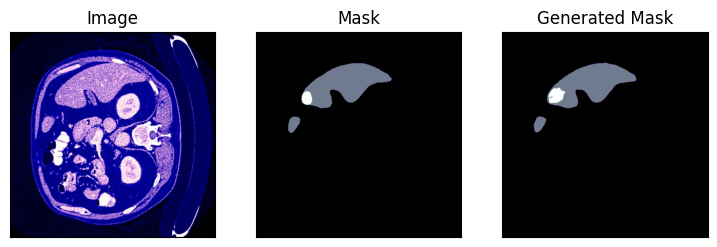

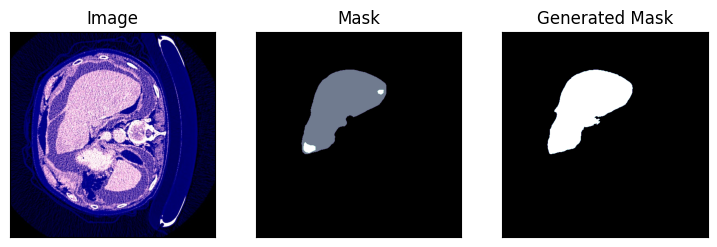

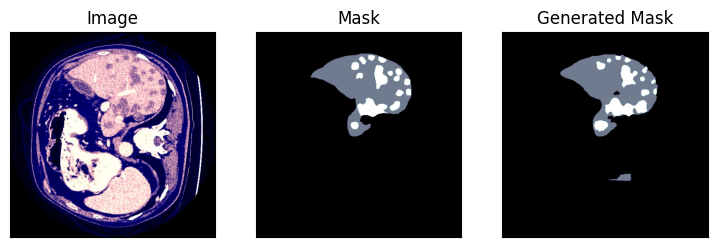

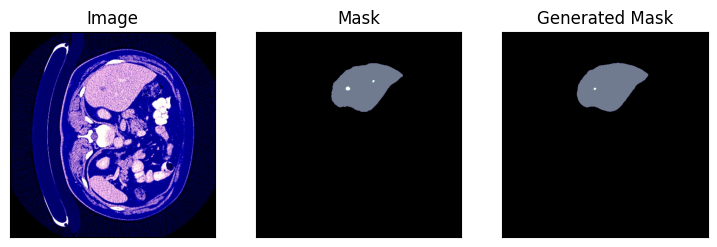

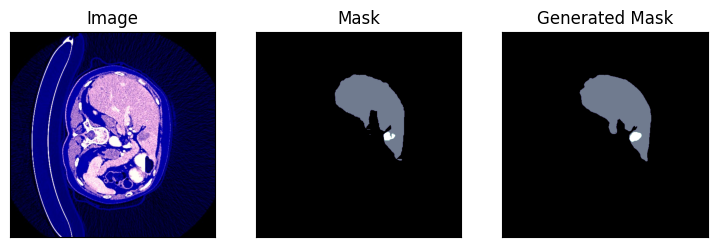

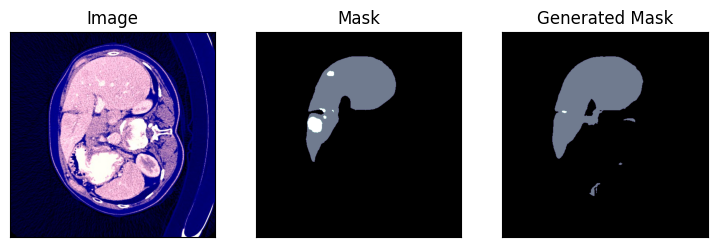

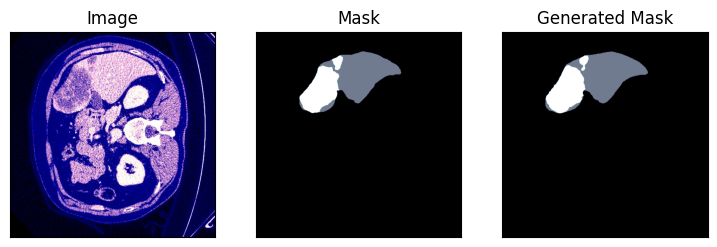

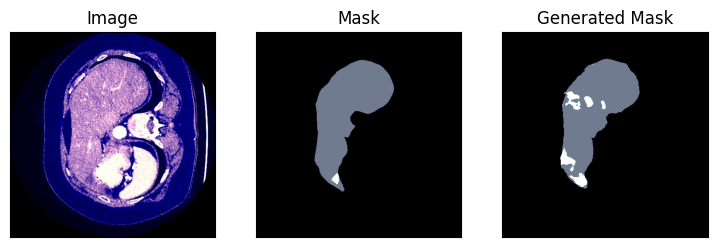

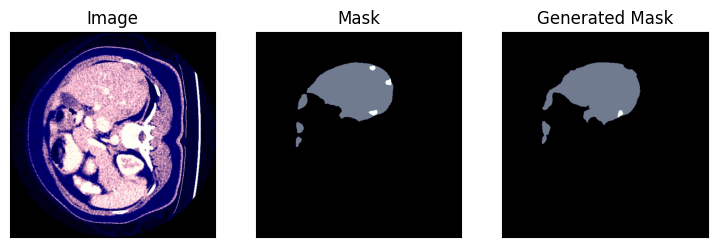

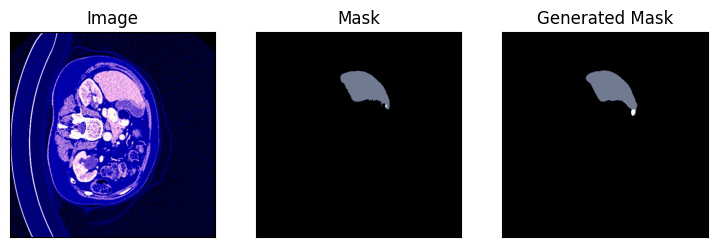

['/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-104_slice_311.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-35_slice_47.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-4_slice_542.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-57_slice_318.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-33_slice_48.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-130_slice_558.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-84_slice_582.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-100_slice_631.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-98_slice_585.jpg',
 '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-98_slice_520.jpg']

In [ ]:
import random

l = random.sample(range(0,1078), 10)


for i in l:
    visualize(image = read_image(valid_x[i]), mask = read_mask(valid_y[i]), generated_mask = read_mask(valid_masks[i]))

valid_x[0:10]